# Local processing of whole-slide images using large_image

This notebook demonstrates how to use [large-image](https://github.com/girder/large_image) to extract pixel data and image metadata from multiresolution whole-slide image files. It is designed to work with a variety of tile sources including OpenSlide, and provides functions for extraction regions, for translating regions across magnifications, and for iterating through a tiled representation of a whole-slide image.

In [1]:
import large_image

INFO:girder:Created LRU Cache for 'tilesource' with 167 maximum size


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'

#### Download a sample whole-slide image

The following code downloads a sample slide from data.kitware.com

In [3]:
wsi_url = 'https://data.kitware.com/api/v1/file/5899dd6d8d777f07219fcb23/download'

wsi_path = 'TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs'

if not os.path.isfile(wsi_path):
    !curl -OJ "$wsi_url"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  643M  100  643M    0     0  16.6M      0  0:00:38  0:00:38 --:--:-- 16.5M
curl: Saved to filename 'TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs'


#### Loading a whole-slide image

In [4]:
ts = large_image.getTileSource(wsi_path)

INFO:girder:Using memcached for large_image caching


Using memcached for large_image caching


The `getTileSource()` function can read a variety of image file formats.  It detects the format automatically and abstracts the differences between them.  Some formats require installing optional dependencies.  For instance, large_image needs to have been installed with extras, such as `pip install .[openslide]`, and your system needs to have the necessary core packages installed.  The available sources are:

* Pyramidal TIFF (.tif, .ptif) - TIFF files that have tiled images stored at different power-of-two resolutions.
* OpenSlide (.svs, .ndpi, .tif, .mrxs) - Any file that can be read by the [OpenSlide library](https://openslide.org/) that has multiple resolutions.
* PIL (.jpg, .png, many others) - Any file that can be read by the [Pillow Python Imaging Library](https://pillow.readthedocs.io/en/latest/handbook/image-file-formats.html).  These files are expected to fit entirely within the available memory as they are not necessarily tiled or multiple resolutions.
* Mapnik/GDAL (.tif, .vrt, others) - Geospatial raster images that can be read via [GDAL](https://www.gdal.org/) and [Mapnik](https://mapnik.org/).

Other tile sources can be added by extending the `FileTileSource` base class, provided that they implement the `getTile` method.


The `getTileSource()` function returns an object of the TileSource class that contains the following utility functions for reading different kinds of information from whole-slide images:

* [getMetadata()](#getMetadata) - Gets basic slide metadata
* [getNativeMagnication()](#getNativeMagnification) - Gets the magnification at which the slide was scanned
* [getMagnicationForLevel()](#getMagnificationForLevel) - Gets the magnification of the specified level in the image pyramid
* [getLevelForMagnification()](#getLevelForMagnification) - Gets the level of the image pyramid closest to a specified magnification
* [tileIterator()](#tileIterator) - Gets an iterator for sequentially iterating through the slide in a tiled fashion at any scale/magnification
* [getSingleTile()](#getSingleTile) - Gets the tile at a specified linear position of the tileIterator.
* [getRegion()](#getRegion) - Gets a region of interest (ROI) within the slide at a specified scale.
* [convertRegionScale()](#convertRegionScale) - Converts a region from one scale to another.
* [getRegionAtAnotherScale()](#getRegionAtAnotherScale) - Gets an image of a region at another scale.

The purpose and typical usage of each of these utility functions is presented in detail below.

<a id="getMetadata"></a>

#### getMetadata()

The `getMetadata()` function of the TileSource class returns a python dict containing basic metadata of a slide:

* *levels* - number of levels in the image pyramid
* *magnification* - native magnification or the magnification associated with the base or highest resolution level at which the slide was scanned.
* *mm_x, mm_y* - width and height of a pixel in millimeters at the base resolution. 
* *sizeX, sizeY* - width and height of the slide in pixels at the base resolution.
* *tileWidth, tileHeight* - width and height of a tile in pixels at base resolution in the slide.

In [5]:
ts.getMetadata()

{'levels': 9,
 'magnification': 20.0,
 'mm_x': 0.0005015,
 'mm_y': 0.0005015,
 'sizeX': 32001,
 'sizeY': 38474,
 'tileHeight': 240,
 'tileWidth': 240}

<a id="getNativeMagnification"></a>

#### getNativeMagnification()

The `getNativeMagnification()` function of the TileSource class returns a python dict containing the magnification and physical size of a pixel in millimeters at the base or highest resolution level at which the slide was scanned

In [6]:
ts.getNativeMagnification()

{'magnification': 20.0, 'mm_x': 0.0005015, 'mm_y': 0.0005015}

<a id="getMagnificationForLevel"></a>

#### getMagnificationForLevel()

The `getMagnificationForLevel()` function of the TileSource class returns a python dict containing the magnification and physical size of a pixel for a specified level in the image pyramid.

In [7]:
# Get the magnification associated with Level 0
ts.getMagnificationForLevel(level=0)

{'level': 0,
 'magnification': 0.078125,
 'mm_x': 0.128384,
 'mm_y': 0.128384,
 'scale': 256.0}

In [8]:
# Get the magnification associated with all levels of the image pyramid
for i in range(ts.levels):
    print('Level-{} : {}'.format(
        i, ts.getMagnificationForLevel(level=i)))

Level-0 : {'magnification': 0.078125, 'scale': 256.0, 'level': 0, 'mm_y': 0.128384, 'mm_x': 0.128384}
Level-1 : {'magnification': 0.15625, 'scale': 128.0, 'level': 1, 'mm_y': 0.064192, 'mm_x': 0.064192}
Level-2 : {'magnification': 0.3125, 'scale': 64.0, 'level': 2, 'mm_y': 0.032096, 'mm_x': 0.032096}
Level-3 : {'magnification': 0.625, 'scale': 32.0, 'level': 3, 'mm_y': 0.016048, 'mm_x': 0.016048}
Level-4 : {'magnification': 1.25, 'scale': 16.0, 'level': 4, 'mm_y': 0.008024, 'mm_x': 0.008024}
Level-5 : {'magnification': 2.5, 'scale': 8.0, 'level': 5, 'mm_y': 0.004012, 'mm_x': 0.004012}
Level-6 : {'magnification': 5.0, 'scale': 4.0, 'level': 6, 'mm_y': 0.002006, 'mm_x': 0.002006}
Level-7 : {'magnification': 10.0, 'scale': 2.0, 'level': 7, 'mm_y': 0.001003, 'mm_x': 0.001003}
Level-8 : {'magnification': 20.0, 'level': 8, 'scale': 1.0, 'mm_y': 0.0005015, 'mm_x': 0.0005015}


<a id="getLevelForMagnification"></a>

#### getLevelForMagnification()

The `getLevelForMagnification()` function of the TileSource class returns the level of the image pyramid associated with a specific magnification or pixel size in millimeters.

In [9]:
# get level whose magnification is closest to 10x
print('Level with magnification closest to 10x = {}'.format(
    ts.getLevelForMagnification(10)))

Level with magnification closest to 10x = 7


In [10]:
# get level whose pixel width is closest to 0.0005 mm
print('Level with pixel width closest to 0.0005mm = {}'.format(
    ts.getLevelForMagnification(mm_x=0.0005)))

Level with pixel width closest to 0.0005mm = 8


<a id="tileIterator"></a>

#### tileIterator()

The `tileIterator()` function provides a iterator for sequentially iterating through the entire slide or a region of interest (ROI) within the slide at any desired resolution in a tile-wise fashion. 

Among others, below are the main optional parameters of tileIterator that cover most of the tile-wise iteration use-cases for image analysis:

* `region` - allows you to specify an ROI within the slide.
* `scale` - allows you to specify the desired magnification/resolution.
* `tile_size` - allows you to specify the size of the tile.
* `tile_overlap` - allows you to specify the amount of overlap between adjacent tiles.
* `format` - allows you to specify the format of the tile image (numpy array or PIL image).

At each iteration the tileIterator outputs a dictionary that includes:

* `tile` - cropped tile image that is lazy loaded or computed only when this element of the dictionary is explicitly accessed.
* `format` - format of the tile.
* `x, y` - (left, top) coordinates in current magnification pixels.
* `width, height` -  size of current tile in current magnification pixels.
* `level` - level of the current tile.
* `magnification` - magnification of the current tile.
* `mm_x, mm_y` - size of the current tile pixel in millimeters.
* `gx, gy` - (left, top) coordinate in base/maximum resolution pixels.
* `gwidth, gheight` - size of of the current tile in base/maximum resolution pixels.

The lazy loading of the tile image allows us to quickly iterate through the tiles and selectively process tiles of interest based on the tile metadata.

The code below shows how to iterate through an ROI within a slide with a specific tile size and at a specific resolution

In [11]:
num_tiles = 0

tile_means = []
tile_areas = []

for tile_info in ts.tileIterator(
    region=dict(left=5000, top=5000, width=20000, height=20000, units='base_pixels'), 
    scale=dict(magnification=20),
    tile_size=dict(width=1000, height=1000),
    tile_overlap=dict(x=50, y=50),
    format=large_image.tilesource.TILE_FORMAT_PIL
):
    
    if num_tiles == 100:
        print('Tile-{} = '.format(num_tiles))
        display(tile_info)
        
    im_tile = np.array(tile_info['tile'])
    tile_mean_rgb = np.mean(im_tile[:, :, :3], axis=(0, 1))
    
    tile_means.append( tile_mean_rgb )
    tile_areas.append( tile_info['width'] * tile_info['height'] )
    
    num_tiles += 1
    
slide_mean_rgb = np.average(tile_means, axis=0, weights=tile_areas)

print('Number of tiles = {}'.format(num_tiles))
print('Slide mean color = {}'.format(slide_mean_rgb))

Tile-100 = 


{'format': 'PIL',
 'gheight': 1000.0,
 'gwidth': 1000.0,
 'gx': 16150.0,
 'gy': 8550.0,
 'height': 1000,
 'iterator_range': {'level_x_max': 27,
  'level_x_min': 5,
  'level_y_max': 27,
  'level_y_min': 5,
  'position': 484,
  'region_x_max': 22,
  'region_y_max': 22},
 'level': 8,
 'level_x': 17,
 'level_y': 9,
 'magnification': 20.0,
 'mm_x': 0.0005015,
 'mm_y': 0.0005015,
 'tile': <PIL.Image.Image image mode=RGBA size=1000x1000 at 0x7FAB5BF2DA50>,
 'tile_overlap': {'bottom': 25, 'left': 25, 'right': 25, 'top': 25},
 'tile_position': {'level_x': 17,
  'level_y': 9,
  'position': 100,
  'region_x': 12,
  'region_y': 4},
 'width': 1000,
 'x': 16150,
 'y': 8550}

Number of tiles = 484
Slide mean color = [214.70349159 142.16679253 172.30744139]


<a id="getSingleTile"></a>

#### getSingleTile()

The `getSingleTile()` function can be used to directly get the tile at a specific position of the tile iterator. 
In addition to the aforementioned parameters of the `tileIterator`, it takes a tile_position parameter that can be used to specify the linear position of the tile of interest. 

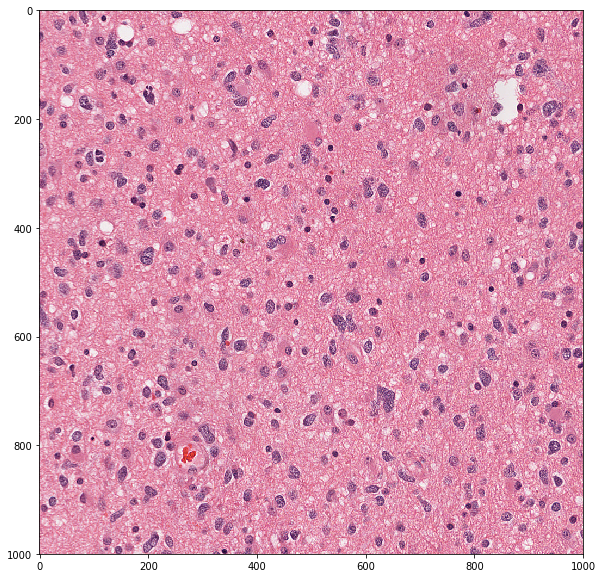

In [12]:
pos = 1000

tile_info = ts.getSingleTile(
    tile_size=dict(width=1000, height=1000), 
    scale=dict(magnification=20), 
    tile_position=pos
)

plt.imshow(tile_info['tile'])

<a id="getRegion"></a>

#### getRegion()

The `getRegion()` function can be used to get a rectangular region of interest (ROI) within the slide at any scale/magnification via the following two parameters:

* `region` - a dictionary containing the (left, top, width, height, units) of the ROI
* `scale` - a dictionary containing the magnification or the physical size of a pixel (mm_x, mm_y)

The following code shows how to read an ROI

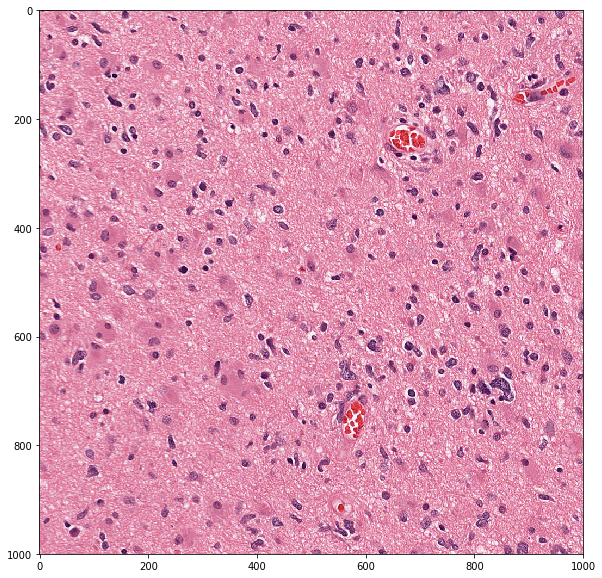

In [13]:
im_roi, _ = ts.getRegion(
    region=dict(left=10000, top=10000, width=1000, height=1000, units='base_pixels'),
    format=large_image.tilesource.TILE_FORMAT_NUMPY
)

plt.imshow(im_roi)

The following code reads the entire slide at a low magnification

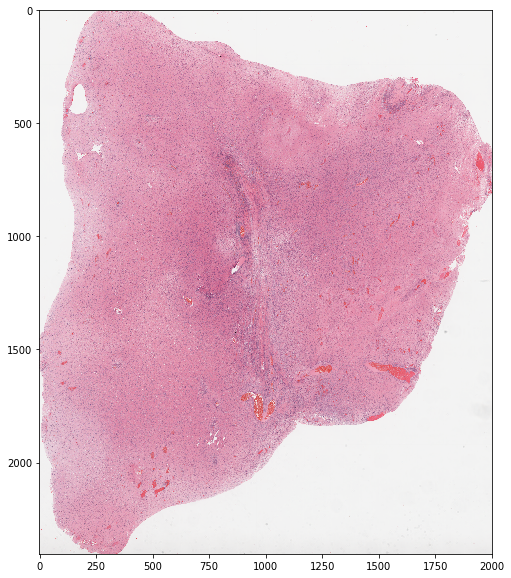

In [14]:
im_low_res, _ = ts.getRegion(
    scale=dict(magnification=1.25), 
    format=large_image.tilesource.TILE_FORMAT_NUMPY
)

plt.imshow(im_low_res)

<a id="convertRegionScale"></a>

#### convertRegionScale()

The `convertRegionScale()` function can be used to convert a region from one scale/magnification to another as illustrated in the following example

In [15]:
tr = ts.convertRegionScale(
    sourceRegion=dict(left=5000, top=5000, width=1000, height=1000, 
                      units='mag_pixels'), 
    sourceScale=dict(magnification=20),
    targetScale=dict(magnification=10),
    targetUnits='mag_pixels'
)

display(tr)

{'height': 500.0,
 'left': 2500.0,
 'top': 2500.0,
 'units': 'mag_pixels',
 'width': 500.0}

<a id="getRegionAtAnotherScale"></a>

#### getRegionAtAnotherScale()

The getRegionAtAnotherScale() function can be used to get an image of a region at another scale.

In [16]:
# get a large region defined at base resolution at a much lower scale
im_roi, _ = ts.getRegionAtAnotherScale(
    sourceRegion=dict(left=5000, top=5000, width=10000, height=10000, 
                      units='base_pixels'),
    targetScale=dict(magnification=1.25),
    format=large_image.tilesource.TILE_FORMAT_NUMPY)

print im_roi.shape

(625, 625, 4)
